In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier


In [2]:
url = 'https://raw.githubusercontent.com/richardcornall/Tensorflow-Pytorch-Ensemble-Machine-Learning-Model-for-Breast-Cancer-Detection-/main/data.csv'
# Load and check data
data = pd.read_csv(url)
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# Drop columns with missing values
data = data.dropna(axis=1)
# Encode 'Diagnosis' column
labelencoder = LabelEncoder()
data['diagnosis'] = labelencoder.fit_transform(data['diagnosis'])
# Separate features and target
X = data.drop(['diagnosis'], axis=1)
y = data['diagnosis']
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
def create_tf_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
tf_model = create_tf_model()

# Fit model
tf_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)


c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
tf_loss, tf_accuracy = tf_model.evaluate(X_test, y_test, verbose=0)
print(f'TensorFlow Model Test Accuracy: {tf_accuracy*100:.2f}%')


TensorFlow Model Test Accuracy: 97.37%


In [8]:
class PyTorchModel(nn.Module):
    def __init__(self, input_size):
        super(PyTorchModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x


In [9]:
# Convert data to PyTorch tensors
X_train_torch = torch.from_numpy(X_train.astype(np.float32))
y_train_torch = torch.from_numpy(y_train.values.astype(np.float32)).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test.astype(np.float32))
y_test_torch = torch.from_numpy(y_test.values.astype(np.float32)).unsqueeze(1)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [10]:
# Initialize model, loss function, optimizer 
input_size = X_train.shape[1]
pytorch_model = PyTorchModel(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

In [11]:
epochs = 50
for epoch in range(epochs):
    pytorch_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [12]:
pytorch_model.eval()
with torch.no_grad():
    outputs = pytorch_model(X_test_torch)
    predicted = (outputs.numpy() > 0.5).astype(int)
    y_test_np = y_test_torch.numpy().astype(int)
    pytorch_accuracy = accuracy_score(y_test_np, predicted)
    print(f'PyTorch Model Test Accuracy: {pytorch_accuracy*100:.2f}%')


PyTorch Model Test Accuracy: 98.25%


In [13]:

def create_tf_model_wrapper():
    model = create_tf_model()
    return model

tf_model_wrapper = KerasClassifier(build_fn=create_tf_model_wrapper, epochs=50, batch_size=32, verbose=0)


In [14]:
class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=32, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None
    
    def fit(self, X, y):
        X_tensor = torch.from_numpy(X.astype(np.float32))
        y_tensor = torch.from_numpy(y.astype(np.float32)).unsqueeze(1)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        input_size = X.shape[1]
        self.model = PyTorchModel(input_size)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        for epoch in range(self.epochs):
            self.model.train()
            for inputs, labels in loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self
    
    def predict(self, X):
        X_tensor = torch.from_numpy(X.astype(np.float32))
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            return (outputs.numpy() > 0.5).astype(int).flatten()
    
    def predict_proba(self, X):
        X_tensor = torch.from_numpy(X.astype(np.float32))
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probs = outputs.numpy()
            return np.hstack((1 - probs, probs))


In [16]:
tf_estimator = tf_model_wrapper
pytorch_estimator = PyTorchClassifier(epochs=50, batch_size=32)

# Voting Classifier with soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('tf', tf_estimator),
        ('pytorch', pytorch_estimator)
    ],
    voting='soft'  # For soft voting
)

In [17]:
ensemble_model.fit(X_train, y_train)

c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


VotingClassifier(estimators=[('tf',
                              KerasClassifier(batch_size=32, build_fn=<function create_tf_model_wrapper at 0x0000019C7EB89E40>, epochs=50, verbose=0)),
                             ('pytorch', PyTorchClassifier())],
                 voting='soft')

In [18]:
#evaluate ensemble
ensemble_pred = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f'Ensemble Model Test Accuracy: {ensemble_accuracy*100:.2f}%')

print(classification_report(y_test, ensemble_pred))


Ensemble Model Test Accuracy: 98.25%
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



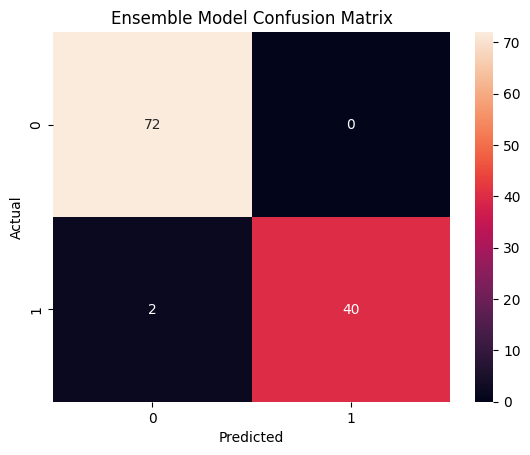

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Ensemble Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
